# Influences in Student's Grades

### Background 🖼

Se ha realizado un estudio para ver si el rendimiento académico de los hijos es influenciado por el nivel académico de sus padres. Por ello, se evaluarán los resultados academicos de los estudiantes en función de varias variables

### Goal 🥅

En este reto tendrás que predecir si los resultados académicos del alumno están influenciados por el nivel educativo de los padres.

### Just a little issue  🤏

Strictly following the instructions we'd be fine by just working an hipotesis test between the dependent features (scores of the students) and only one independent variable influencing the results (their parental level of education).

Yet, we've been given along a few other features that might add some variance to our models besides our test file is missing the parental level of education so...based on this latter we should conclude that the dependent variable is opposites🔀 from the one in the main goal 🙃.

However, at this point we'll do EDA as usual and try to apply & implement the most suitable MLAlgorithm. Afterwards we plan to do proper hypotesis testing as well.

### Imports 🗃

In [1]:
# Yolo!
import warnings
warnings.filterwarnings('ignore')

# Scientific and Data Manipulation Libraries :
import numpy as np
import scipy as sp
from scipy import stats 
import pandas as pd
import statsmodels.api as sm
from pprint import pprint
from collections import Counter
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import ListedColormap
import seaborn as sb
import ppscore as pps

# Pre-Processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline

# ML Models
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, f1_score

# Other Settings
%matplotlib inline
np.random.seed(10)

### Methods 🛠

In [2]:
# methods to go by
def check_distribution(df):
    '''Returns a Multiplot Histogram for each variable in input df '''
    # Inputs
    df = pd.DataFrame(df)
    variables = df.columns
    n_rows = 3
    n_cols = 4
    
    #Plot
    sb.set(font_scale=1.2) 
    fig=plt.figure(figsize=(15,7))
    fig.patch.set_facecolor('slategrey')
    fig.suptitle('FEATURE DISTRIBUTION')
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=25, ax=ax)
        ax.set_title(var_name, size=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    fig.tight_layout()
    plt.show()
    plt.close('all')
    
    
def feature_plots(df,feature):
    '''plots input feature and it's relation with other variables in list below'''
    feature_list = ['target', 'gender', 'lunch','test_prep']
    # figure setting
    fig = plt.figure(figsize=(16,9))
    
    for i,feat in enumerate(feature_list,start=1):
        
        if feat == str(feature):
            # basic rate plot
            plt.subplot(2, 2, i)
            plt.grid(color='k', linestyle='dotted', linewidth=0.5, axis='x')
            selection = df[str(feature)].value_counts(normalize=True).mul(100)
            ax = selection.plot(kind ='barh', color=['indianred', 'lightseagreen'],
                                alpha=0.5, edgecolor='purple')
            ax.xaxis.set_major_formatter(mtick.PercentFormatter())
            plt.xlabel('rate')
            plt.xticks(rotation=0)
            plt.title(f'{feature} Rate Distribution')
            
        else:
            # Combined with other features
            plt.subplot(2, 2, i)
            plt.grid(color='black', linestyle='--', linewidth=0.5)
            ax = sb.countplot(data=df, x=feature, palette='viridis_r', alpha=0.5 ,hue=feat)
            plt.xlabel('')
            plt.legend(loc='upper right')
            plt.title(f'Combined with {feat}')
    plt.suptitle(f'{feature.upper()} Feature Comparative', fontsize=18)
    plt.tight_layout()
    plt.show()
    plt.close('all')
    
    
def select_features(X_train, y_train, X_test):
    # Select all features
    fs = SelectKBest(score_func=f_classif, k='all' )
    
    # Learn relationship from training data
    fs.fit(X_train, y_train)
   
    return fs

def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.4f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")

            
def check_variance_homogeneity(group1, group2, group3):
    test_stat_var, p_value_var= stats.levene(group1, group2, group3, center='median')
    print("p value:%.4f" % p_value_var)
    if p_value_var <0.05:
        print("Reject null hypothesis >> The variances of the samples are different.")
    else:
        print("Fail to reject null hypothesis >> The variances of the samples are same.")

### The Data 💾

Glossary:

Dependent variable

- Parental level of education : Nivel educativo del padres
    - high school: 0,

    - some high school: 1,

    - some college: 2,

    - associate's degree: 3,

    - bachelor's degree: 4,

    - master's degree: 5

Independent Variables
- Gender : Sexo del estudiante

- Lunch : Si tiene becas comedor

- Test preparation course : Asiste a academia

- Math score : Puntuación en Mates

- Reading score : Comprensión Lectora

- Writing score : Puntuación de escritura



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   800 non-null    int64 
 1   gender                       800 non-null    object
 2   parental level of education  800 non-null    int64 
 3   lunch                        800 non-null    object
 4   test preparation course      800 non-null    object
 5   math score                   800 non-null    int64 
 6   reading score                800 non-null    int64 
 7   writing score                800 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 50.1+ KB


None

Any duplicated rows? : False


,Unnamed: 0,parental level of education,math score,reading score,writing score
count,800.00,800.00,800.00,800.00,800.00
mean,499.91,2.04,66.57,69.14,67.83
std,288.80,1.52,15.71,14.82,15.74
min,0.00,0.00,13.00,27.00,23.00
25%,243.25,1.00,56.00,60.00,58.00
50%,500.50,2.00,67.00,70.00,68.00
75%,748.25,3.00,78.00,79.00,79.00
max,999.00,5.00,100.00,100.00,100.00


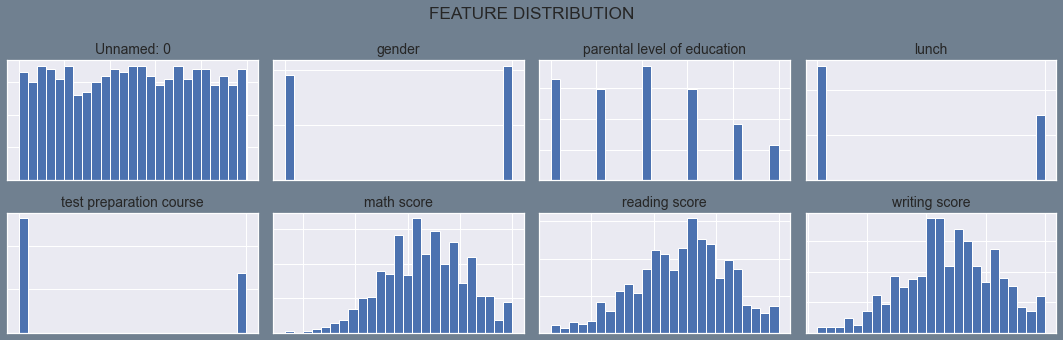

,Unnamed: 0,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,764,female,1,standard,none,62,76,67
1,866,male,4,standard,none,79,57,58
2,208,female,2,standard,none,77,86,84
3,337,female,0,free/reduced,none,45,46,49
4,323,male,3,standard,completed,82,83,85
5,84,female,3,free/reduced,none,32,41,39
6,836,female,1,free/reduced,completed,53,70,65
7,90,male,2,free/reduced,none,57,47,42
8,37,male,0,free/reduced,none,67,65,54
9,91,male,1,standard,none,74,71,70


In [3]:
# first peeks
df = pd.read_csv(r"C:\Users\motxi\Documents\HACKATHONS\NUWE\Student Factors\train.csv")
display(df.info())
dups = df.duplicated()
print(f'Any duplicated rows? : {dups.any()}')
display(df.describe())
check_distribution(df)
display(df.head(10))




# EDA  🔬
____


Based on the above:
- Scores seem normally distributed

- From the only balanced categorical feature is Gender

- Since the column "Unnamed: 0" is unlabelled and it's distribution is uniform we may assume its a previous index so we can drop it safely.

- We'll also shorten the target feature ("parental level of education") to "target" , and also "test preparation course" to "test_prep" for the sake of simplicity.

In [4]:
# cleaning
df.drop('Unnamed: 0', axis=1, inplace=True)
df.rename(columns={'parental level of education':'target', 'test preparation course':'test_prep'}, inplace=True)

### Target variable 🎯 

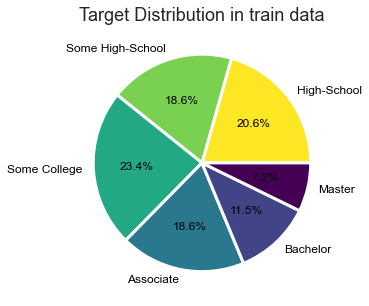

Counter({2: 187, 0: 165, 1: 149, 3: 149, 4: 92, 5: 58})


In [5]:
# plot target variable outcome
fig = plt.figure(figsize=(10,5))

# Wedge properties
wp = { 'linewidth' : 3, 'edgecolor' : "white" }

df.groupby('target').size().plot(kind='pie',
                                 y='target', 
                                 labels=['High-School','Some High-School','Some College','Associate','Bachelor','Master'],
                                 label='',
                                 cmap='viridis_r',
                                 textprops={'fontsize':12, 'color':'black'},
                                 wedgeprops=wp,
                                 autopct='%1.1f%%') 

plt.title('Target Distribution in train data', fontsize=18)

plt.show()
plt.close()
print(Counter(df['target']))

Parental level of Education contains 5 unbalanced groups. Being College the biggest group (**23,4%**) and Master's Degree the smallest (**7,2%**).

### Independent variables 🧱


#### Grades:

Grading scores are distributed in the three Subjects (maths, reading & writing).

At some point we might have to get the average of the scores and possibly use discrete quantizantion to translate the different average qualifications of each student into the Anglosaxon grading scheme or any alike transformation. 

![Table of Grades](https://studyportals-cdn2.imgix.net/59773a3bb97a3.jpg?max-w=660&max-h=532&fit=crop&auto=format,compress&q=40)

Meanwhile we'll go for the objective showing the density estimamtes of the grades per subject versus parental level of education.

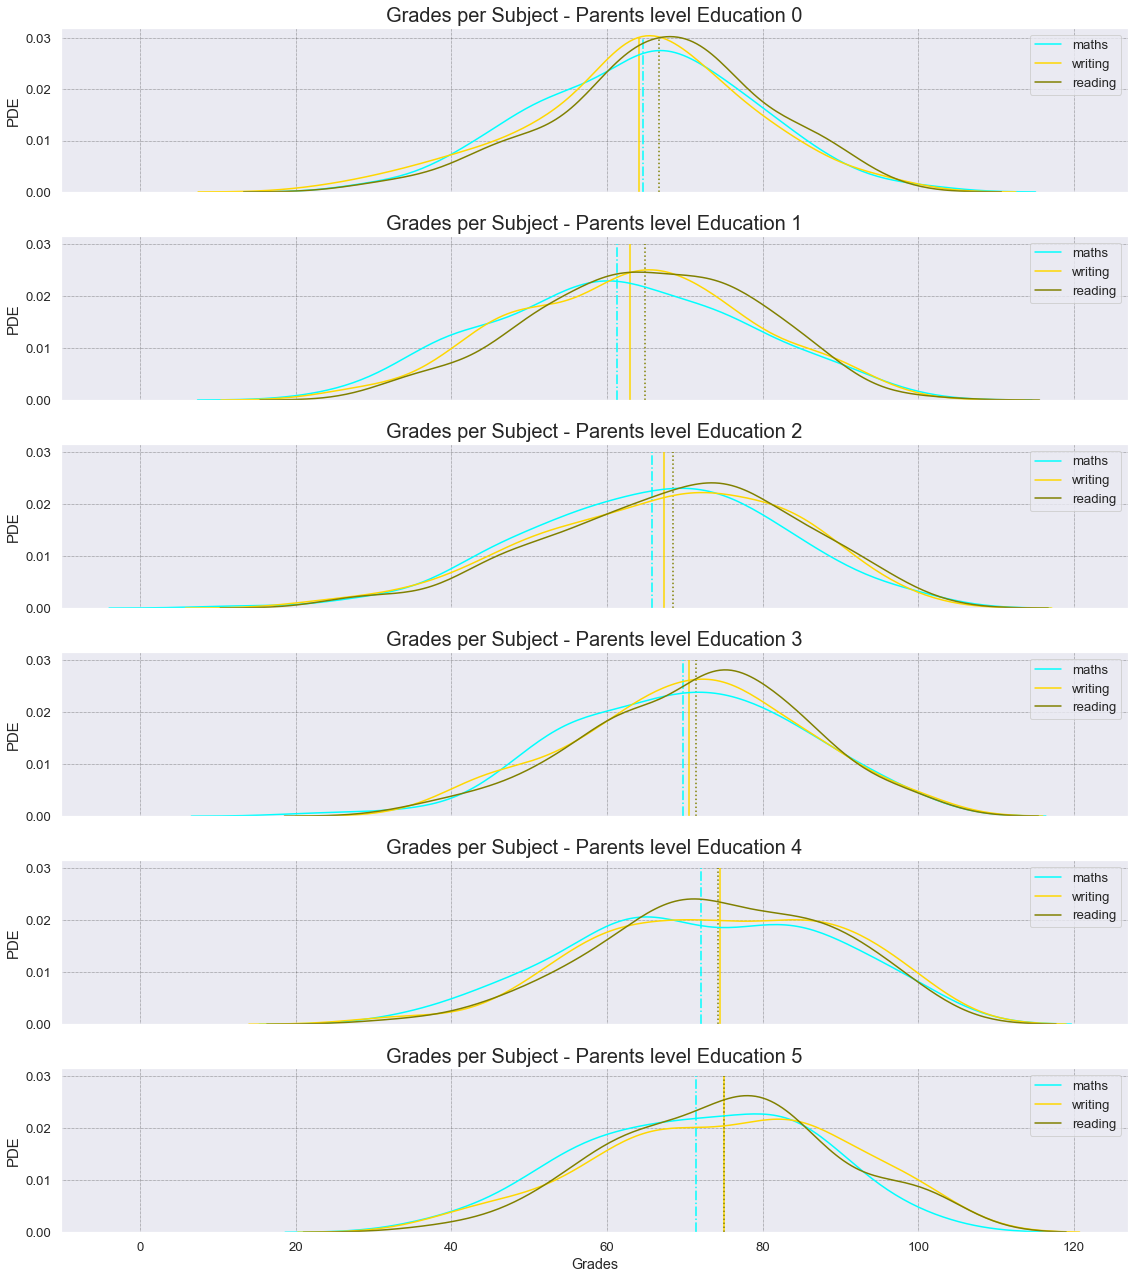

In [6]:
# plot
fig, ax = plt.subplots(6,1, sharex='col', sharey='row', figsize=(16,18))
for i in range(6):
    plt.subplot(6,1,i+1)
    sb.kdeplot(df['math score'].loc[df['target']==i], color='cyan')
    sb.kdeplot(df['writing score'].loc[df['target']==i], color='gold')
    sb.kdeplot(df['reading score'].loc[df['target']==i], color='olive')

    # aestethics
    plt.xlabel('Grades')
    plt.ylabel("PDE", fontsize = 15)
    plt.title(f'Grades per Subject - Parents level Education {i}', fontsize=20)
    plt.grid(color='k', linestyle='dotted', linewidth=0.5)
    plt.legend(labels=['maths', 'writing', 'reading'])
    plt.vlines(x=df['math score'].loc[df['target']==i].mean(), ymin=0, ymax=0.030, color='aqua',linestyle='dashdot')
    plt.vlines(x=df['writing score'].loc[df['target']==i].mean(), ymin=0, ymax=0.030, color='gold')
    plt.vlines(x=df['reading score'].loc[df['target']==i].mean(), ymin=0, ymax=0.030, color='olive',linestyle='dotted')

plt.tight_layout()
plt.show()
plt.close()



- 🤔 In the case of the target column we can dare to say that 0 and 1 are misslabelled since it makes a lot of sense that "Some High-School" should be merged together, or at least come before "High-School" (and the plots above support my idea). So one of the drawbacks is that we're loosing the ordinal "nature" of such variable, and it gets worst because It is the target Itself and consequently we'll have to be tested with such variable predictions so there's no possible way to mend it. In other words...¿do we believe a ML Algorithm learning to discern between parental educational levels should care about the name of the High Schools?!🤷‍♂️


- Parent's Level Education 1 (some High-School) contains the lowest scores in the sample. In contrast level 5 (Master's Degree) gets the higher grades. In a sense we can see the average Student's scores slightly improves when their parent's level of tuition goes up. (maybe weak correlation, but again, since level 0 and 1  are mislabeled we can get spurious readings altering the function of their relation, making it harder for the algorithm to discern between categories that are "too similar", thus worsening both precision and accuracy.) 


- While best average scores are found in the Reading subject we see that Maths gets always third place. 


- Incidentally we can observe that as long as the parental level of education grows the writing scores gradually approach the reading scores (wich are the best) until they overlap each other. 


>🤔 This latter could be linked to some culturally-active household habits of the parents as well as the access to books. (i.e Suppose there's a library at home because parents have the routine of reading daily)

#### Gender

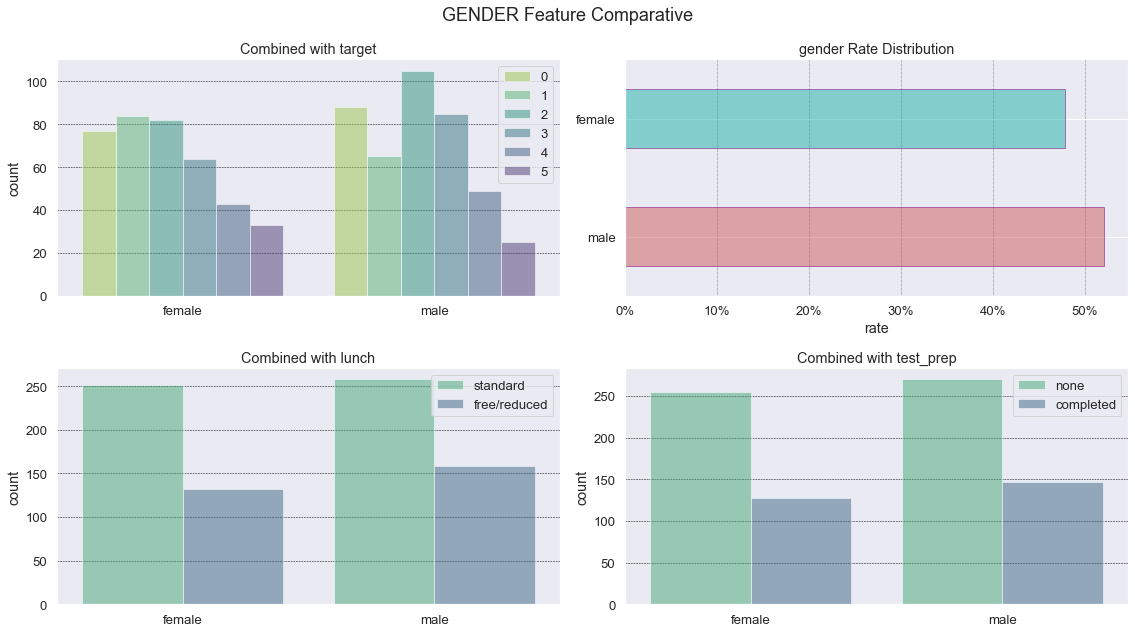

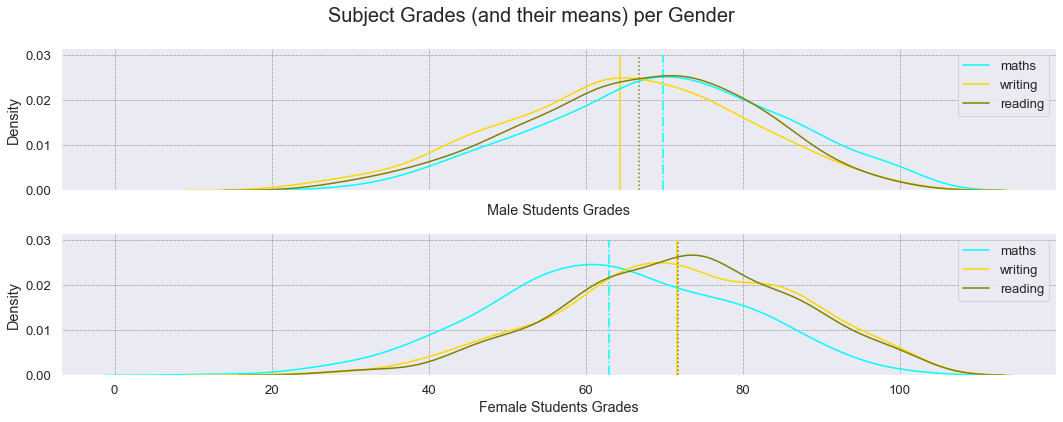

In [7]:
# compare with other features
feature_plots(df, 'gender')

# compare gender with grades
fig = plt.figure(figsize=(15,6))

# male
ax1 = plt.subplot(2,1,1)
sb.kdeplot(df['math score'].loc[df['gender']=='male'], color='cyan')
sb.kdeplot(df['writing score'].loc[df['gender']=='male'], color='gold')
sb.kdeplot(df['reading score'].loc[df['gender']=='male'], color='olive')
# aestethics
ax1.set_xlabel('Male Students Grades')
plt.grid(color='k', linestyle='dotted', linewidth=0.5)
plt.legend(labels=['maths', 'writing', 'reading'])
plt.vlines(x=df['math score'].loc[df['gender']=='male'].mean(), ymin=0, ymax=0.030, color='cyan', linestyle='dashdot')
plt.vlines(x=df['writing score'].loc[df['gender']=='male'].mean(), ymin=0, ymax=0.030, color='gold')
plt.vlines(x=df['reading score'].loc[df['gender']=='male'].mean(), ymin=0, ymax=0.030, color='olive', linestyle='dotted')

#female
ax2 = plt.subplot(2,1,2)
sb.kdeplot(df['math score'].loc[df['gender']=='female'], color='cyan')
sb.kdeplot(df['writing score'].loc[df['gender']=='female'], color='gold')
sb.kdeplot(df['reading score'].loc[df['gender']=='female'], color='olive')
ax2.set_xlabel('Female Students Grades')
# aestethics
plt.suptitle(f'Subject Grades (and their means) per Gender', fontsize=20)
plt.grid(color='k', linestyle='dotted', linewidth=0.5)
plt.legend(labels=['maths', 'writing', 'reading'])
plt.vlines(x=df['math score'].loc[df['gender']=='female'].mean(), ymin=0, ymax=0.030, color='cyan', linestyle='dashdot')
plt.vlines(x=df['writing score'].loc[df['gender']=='female'].mean(), ymin=0, ymax=0.030, color='gold')
plt.vlines(x=df['reading score'].loc[df['gender']=='female'].mean(), ymin=0, ymax=0.030, color='olive', linestyle='dotted')

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.tight_layout()
plt.show()
plt.close()


- Rate distribution of Genders is balanced.


- Regarding the Parental level of education, the main difference among student's gender proportion is that groups 1 & 2 (Some Hig-School & Some College) are balanced in the case of female students whereas in the case of male students is notably unbalanced.


- Lunch and preparation course present the same proportions amongst both genders


- When comparing Grades we see male students means are less sparse than the ones of their female peers. Incidentally maths is the tougher subject for female students while male students get their best grades at it.

#### Lunch 

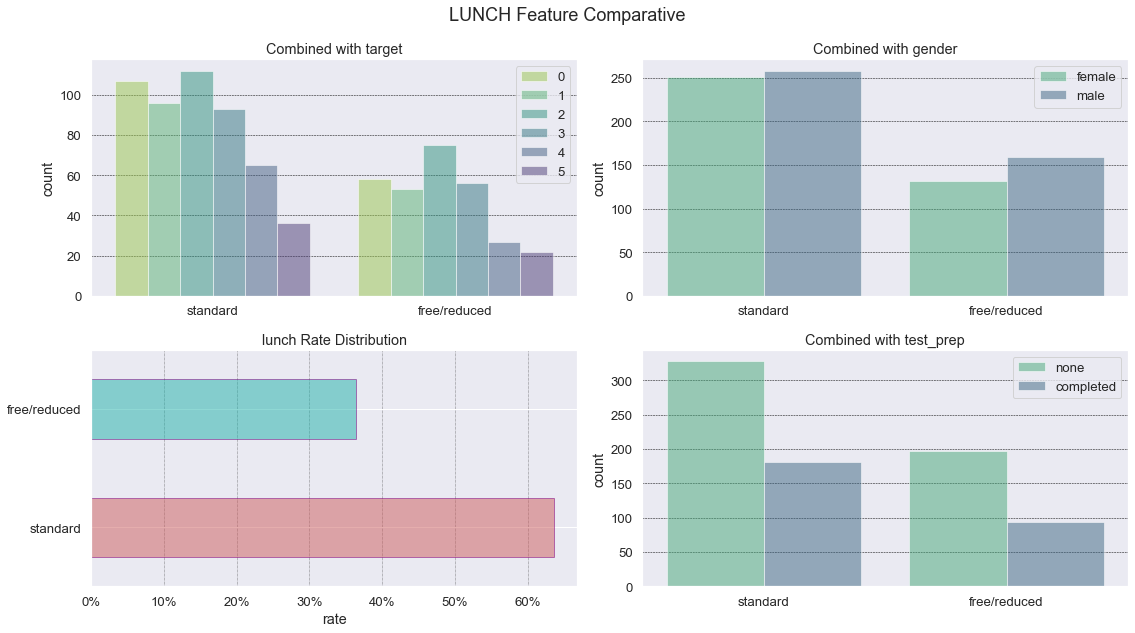

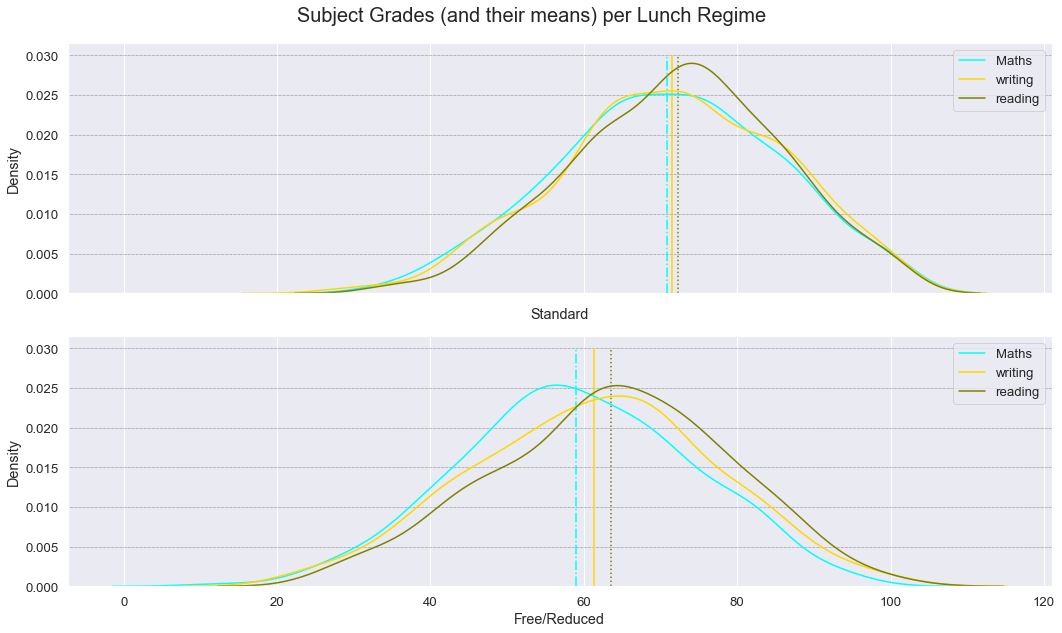

In [8]:
# compare
feature_plots(df, 'lunch')

# compare lunch with grades
fig = plt.figure(figsize=(15,9))

# standard
ax1 = plt.subplot(2,1,1)
sb.kdeplot(df['math score'].loc[df['lunch']=='standard'], color='cyan')
sb.kdeplot(df['writing score'].loc[df['lunch']=='standard'], color='gold')
sb.kdeplot(df['reading score'].loc[df['lunch']=='standard'], color='olive')

# aestethics
ax1.set_xlabel('Standard')
plt.grid(color='k', linestyle='dotted', linewidth=0.5, axis='y')
plt.legend(labels=['Maths', 'writing', 'reading'])
plt.vlines(x=df['math score'].loc[df['lunch']=='standard'].mean(), ymin=0, ymax=0.030, color='cyan', linestyle='dashdot')
plt.vlines(x=df['writing score'].loc[df['lunch']=='standard'].mean(), ymin=0, ymax=0.030, color='gold')
plt.vlines(x=df['reading score'].loc[df['lunch']=='standard'].mean(), ymin=0, ymax=0.030, color='olive', linestyle='dotted')

# free/reduced
ax2 = plt.subplot(2,1,2)
sb.kdeplot(df['math score'].loc[df['lunch']=='free/reduced'], color='cyan')
sb.kdeplot(df['writing score'].loc[df['lunch']=='free/reduced'], color='gold')
sb.kdeplot(df['reading score'].loc[df['lunch']=='free/reduced'], color='olive')

ax2.set_xlabel('Free/Reduced')
# aestethics
plt.grid(color='k', linestyle='dotted', linewidth=0.5, axis='y')
plt.legend(labels=['Maths', 'writing', 'reading'])
plt.vlines(x=df['math score'].loc[df['lunch']=='free/reduced'].mean(), ymin=0, ymax=0.030, color='cyan', linestyle='dashdot')
plt.vlines(x=df['writing score'].loc[df['lunch']=='free/reduced'].mean(), ymin=0, ymax=0.030, color='gold')
plt.vlines(x=df['reading score'].loc[df['lunch']=='free/reduced'].mean(), ymin=0, ymax=0.030, color='olive', linestyle='dotted')

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.suptitle(f'Subject Grades (and their means) per Lunch Regime', fontsize=20)
plt.tight_layout()
plt.show()
plt.close()

- Grades from students with Free/Reduced Lunch regime are sparser and also 10 points below the ones with standard Lunch regime. 


>🤔Entering in causality we can't theorize about the exact household situations of each student but...on the other hand we can do it in biological terms since, as far as I know, there's Academical studies that proved correlation between the grades of a student and a evenly scheduled meal regime all-around the day, basically concluding that students need food for their thoughts (oyes! 🧏‍♂️the brain weights 2% of total body mass but consumes 20% of all oxigen and Glucose entering the body!).

#### Test Preparation Course

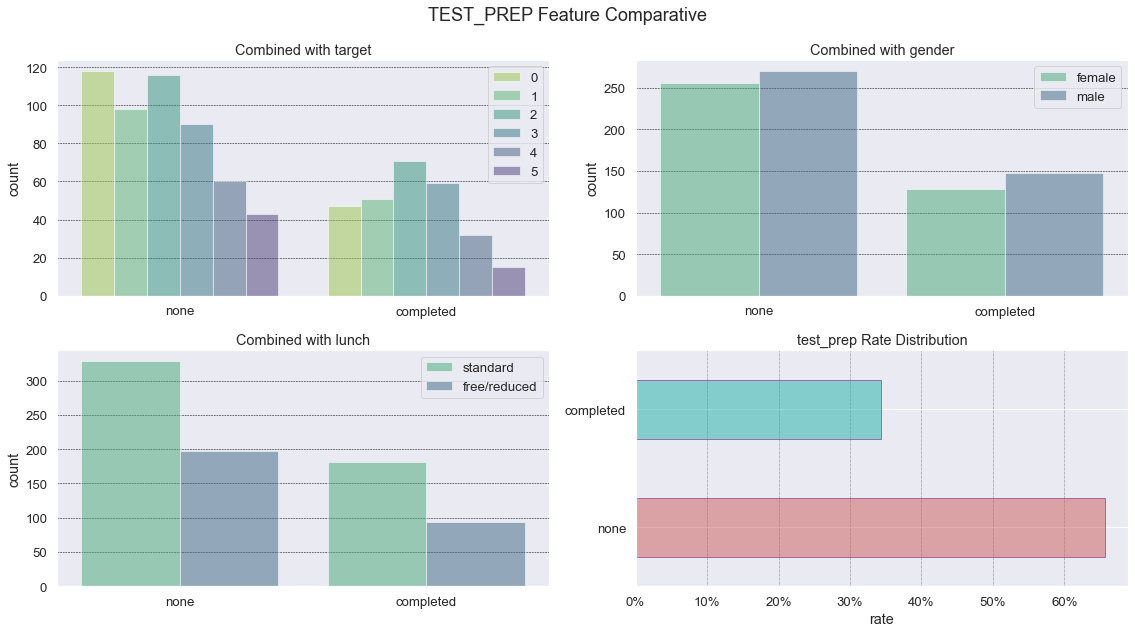

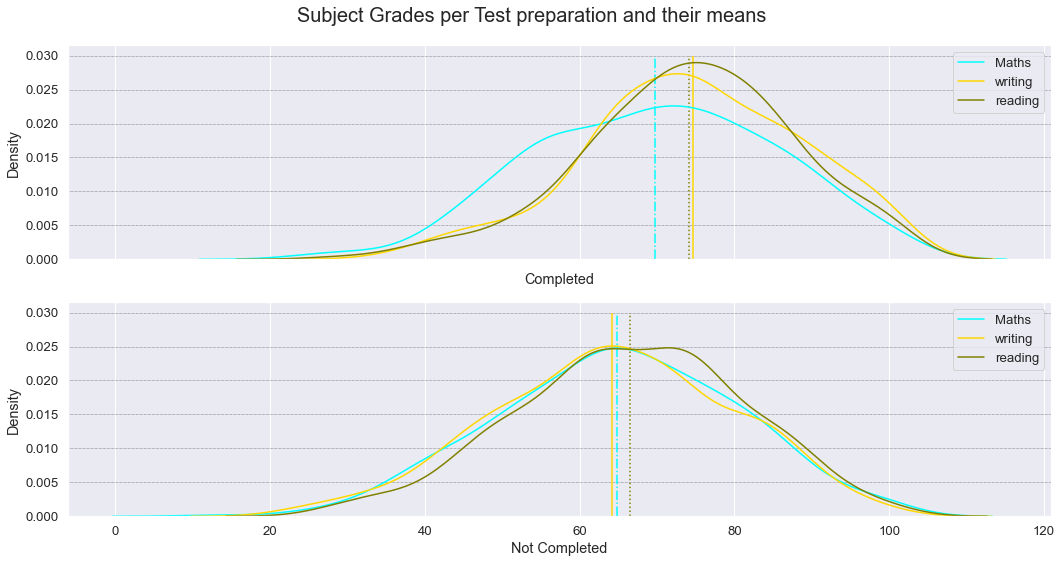

In [9]:
# get plots
feature_plots(df, 'test_prep')

# compare lunch with grades
fig = plt.figure(figsize=(15,8))

# standard
ax1 = plt.subplot(2,1,1)
sb.kdeplot(df['math score'].loc[df['test_prep']=='completed'], color='cyan')
sb.kdeplot(df['writing score'].loc[df['test_prep']=='completed'], color='gold')
sb.kdeplot(df['reading score'].loc[df['test_prep']=='completed'], color='olive')

# aestethics
ax1.set_xlabel('Completed')
plt.grid(color='k', linestyle='dotted', linewidth=0.5, axis='y')
plt.legend(labels=['Maths', 'writing', 'reading'])
plt.vlines(x=df['math score'].loc[df['test_prep']=='completed'].mean(), ymin=0, ymax=0.030, color='cyan', linestyle='dashdot')
plt.vlines(x=df['writing score'].loc[df['test_prep']=='completed'].mean(), ymin=0, ymax=0.030, color='gold')
plt.vlines(x=df['reading score'].loc[df['test_prep']=='completed'].mean(), ymin=0, ymax=0.030, color='olive', linestyle='dotted')
# free/reduced
ax2 = plt.subplot(2,1,2)
sb.kdeplot(df['math score'].loc[df['test_prep']=='none'], color='cyan')
sb.kdeplot(df['writing score'].loc[df['test_prep']=='none'], color='gold')
sb.kdeplot(df['reading score'].loc[df['test_prep']=='none'], color='olive')

ax2.set_xlabel('Not Completed')
# aestethics
plt.grid(color='k', linestyle='dotted', linewidth=0.5, axis='y')
plt.legend(labels=['Maths', 'writing', 'reading'])
plt.vlines(x=df['math score'].loc[df['test_prep']=='none'].mean(), ymin=0, ymax=0.030, color='cyan', linestyle='dashdot')
plt.vlines(x=df['writing score'].loc[df['test_prep']=='none'].mean(), ymin=0, ymax=0.030, color='gold')
plt.vlines(x=df['reading score'].loc[df['test_prep']=='none'].mean(), ymin=0, ymax=0.030, color='olive', linestyle='dotted')


ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.suptitle(f'Subject Grades per Test preparation and their means', fontsize=20)
plt.tight_layout()
plt.show()
plt.close()

- Clearly, students that have prepared their Tests deliver better grades .

>So far we understood the variables somehow are related to the scores, but are they really related to the objective?  I mean...we were just asked to find relations between parental level of education and Students's performace

### Correlations and Predictive Power Score 🔗

We use a pairplot and heatmaps with df.corr() method from python with the variation in the method (kendall and Spearman) to spot linear and monotonic correlations between Numerical Features  method.

PPS we'll be used to spot Non-linear Correlations, with the advantage that can be also used with categorical features and since it's not simmetric it'll help in case of feature selection.

Also we create an average score feature to control it's correlation levels

In [10]:
# create column average_score
df['total_score'] = (df['math score']+df['reading score']+df['writing score'])

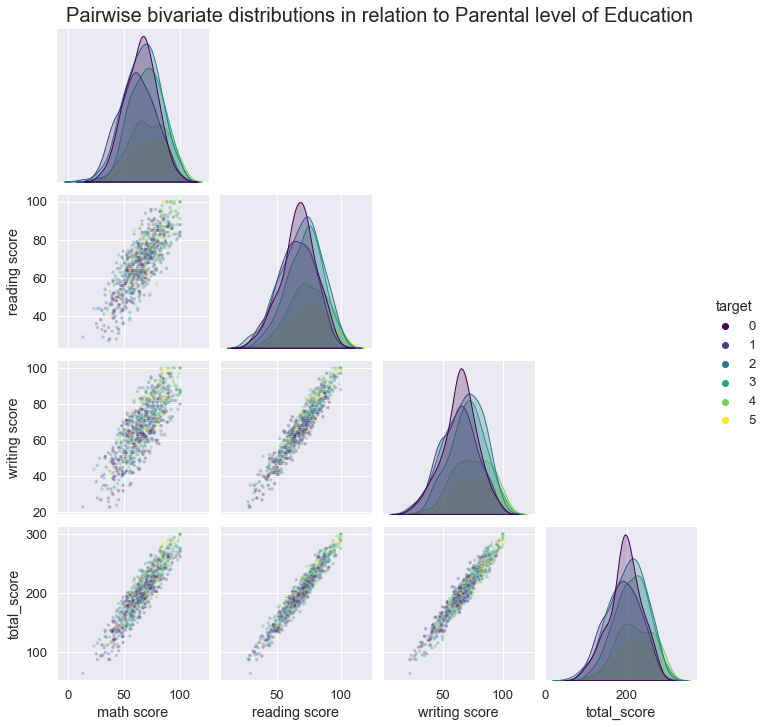

In [11]:
# get pairplot

sb.pairplot(df, hue='target', kind='scatter', 
            palette='viridis',
            corner=True,
            plot_kws={'alpha':0.3, 's':12}
           )
plt.suptitle('Pairwise bivariate distributions in relation to Parental level of Education', fontsize=20, y=1.01)
plt.show()
plt.close()

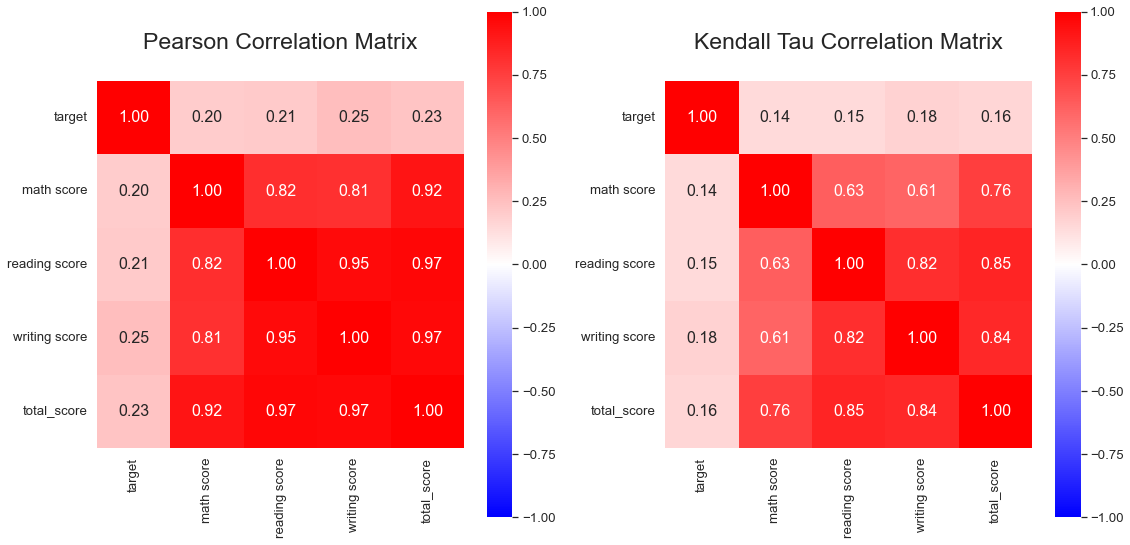

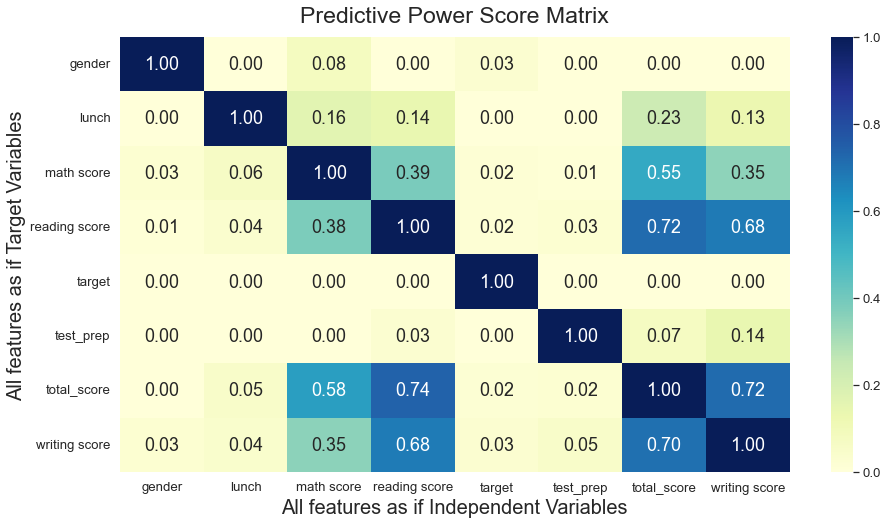

In [12]:
# get corr matrixes (Linear+Monotonic+PPS)

df_corr_p = df.corr(method='pearson')
df_corr_kt = df.corr(method='kendall')
# Plot
colormap = plt.cm.RdBu
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

 
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(data=df_corr_p,
                      square=True,
                      annot=True,
                      fmt=".2f",
                      annot_kws={"size":16},
                      cmap='bwr',
                      linecolor = 'black',
                      vmin=-1,
                      vmax=1,
                      ax=ax1)
ax1.set_title('Pearson Correlation Matrix', fontsize=23, y=1.07)
 
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(data=df_corr_kt,
                      square=True,
                      annot=True,
                      fmt=".2f",
                      annot_kws={"size":16},
                      cmap='bwr',
                      vmin=-1,
                      vmax=1,
                      ax=ax2)
ax2.set_title("Kendall Tau Correlation Matrix", fontsize=23, y=1.07)
plt.tight_layout()
sb.set_style()
plt.show()
plt.close()

# plot PPS
plt.figure(figsize=(15,8))
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sb.heatmap(data=matrix_df, 
           vmin=0, 
           vmax=1,
           fmt=".2f",
           annot_kws={"size":18},
           cmap="YlGnBu",
           linewidths=0,
           annot=True
          )
plt.title("Predictive Power Score Matrix", fontsize=23, y=1.02)
plt.xlabel('All features as if Independent Variables', fontsize=20)
plt.ylabel('All features as if Target Variables', fontsize=20)
plt.show()
plt.close()

- Writing and reading scores are 95% linearly correlated (and 82% "monotonic-ish") and in turn both are 80% linearly correlated with math score.


- PPS shows some symmetry, although:
    1. Even if Writing and Reading scores have the same levels of pps in both ways, it must be noted that Reading scores are slightly better at predicting Math scores.
    2. Writing score is better at explaining test_prep than Reading score.
    3. Categorical features don't seem to have much predictive power

# Feature Engineering 🧩
___

### Splits

In [13]:
# do train/test split and check shapes
X = df.drop(columns='target')
y = df[['target']]

# encode 
X = pd.get_dummies(X)

# create column total_score
X.drop(columns=['writing score', 'reading score', 'math score'], inplace=True)


# train/test splits
X_train, X_test,y_train, y_test = (train_test_split(X,y, test_size=0.20, random_state=1))
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (640, 7)
y_train shape: (640, 1)
X_test shape: (160, 7)
y_test shape: (160, 1)


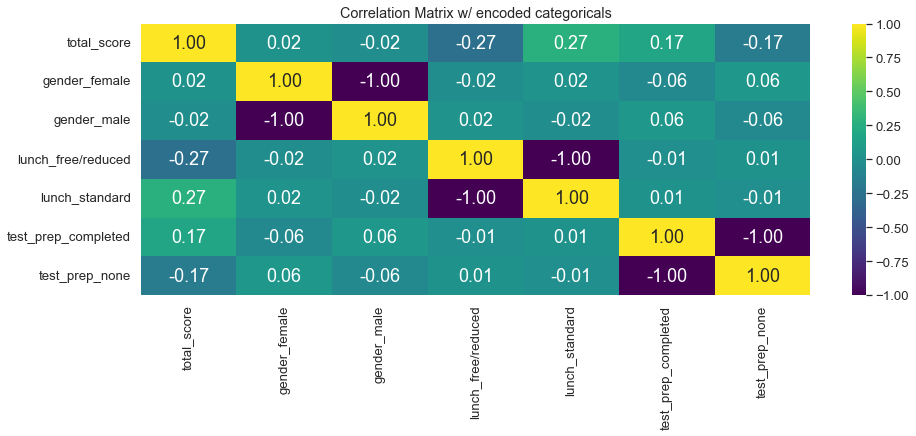

In [14]:
# Check correlation again now with the encoded categoricals
df_corr = X_train.corr('kendall')
fig = plt.figure(figsize=(15,5))
sb.heatmap(df_corr, 
           annot=True,
           fmt=".2f",
           annot_kws={"size":18},
           cmap='viridis', 
           linecolor = 'black')

plt.yticks(rotation=0)
plt.title('Correlation Matrix w/ encoded categoricals')
plt.show()
plt.close()

- "Test preparation" variable has a weak negative correlation with grading scores, wich doesn't make much sense until we see that the encoder assigned 1 to "None" and 0 to "Completed". And so playing along with the encoder we could understand that the test preparation enhances students' writing & reading skills.


- Encoded categoricals show weak correlation with the Scores.

### Scaling

In [15]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### Balance target


Given the small size of the dataset , I prefer to use Oversampling techniques (otherwise we'd end up with 250 features aprox loosing too much information).

Also, given the null predictive power of the variables we'll make emphasis on correlated variables. This means linear algorithms won't have a great time so CART or ensemble Algorithms like Voting/Boosting/Bagging will be my election when trying to mitigate the noise caused by their correlation 

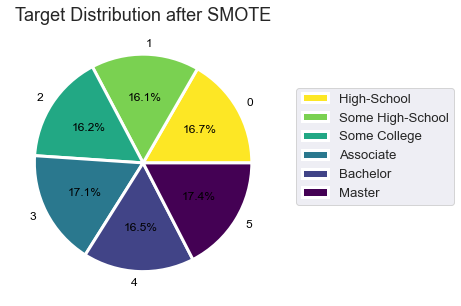

Counter({5: 115, 3: 113, 0: 110, 4: 109, 2: 107, 1: 106})


In [16]:
# apply smote

over = SMOTETomek(random_state=4)

X_su, y_su = over.fit_resample(X_train, y_train)

# plot target variable outcome
fig = plt.figure(figsize=(8,5))

# Wedge properties
wp = { 'linewidth' : 3, 'edgecolor' : "white" }

y_su.groupby('target').size().plot(kind='pie',
                                 y='target', 
                                 label='',
                                 cmap='viridis_r',
                                 textprops={'fontsize':12, 'color':'black'},
                                 wedgeprops=wp,
                                 autopct='%1.1f%%') 

plt.title('Target Distribution after SMOTE', fontsize=18)
plt.legend(labels=['High-School','Some High-School','Some College','Associate','Bachelor','Master'],
           bbox_to_anchor=(1.04, 0.8), loc="upper left")
sb.set()
plt.show()
plt.close()
print(Counter(y_su['target']))

# Models 📎
___

### Spot Checking Algorithms

In [17]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)

models,predictions = clf.fit(X_su, X_test, y_su, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 20.35it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LinearSVC                          0.26               0.29    None      0.23   
RidgeClassifierCV                  0.26               0.29    None      0.23   
RidgeClassifier                    0.26               0.29    None      0.23   
NearestCentroid                    0.26               0.28    None      0.26   
CalibratedClassifierCV             0.23               0.27    None      0.20   
GaussianNB                         0.24               0.27    None      0.24   
SVC                                0.24               0.26    None      0.25   
Perceptron                         0.22               0.26    None      0.21   
LinearDiscriminantAnalysis         0.23               0.26    None      0.21   
LogisticRegression                 0.22               0.25    None      0.21   
LabelSpreading                     0.26 

### Hyper-parameter Tunning 🎛

In [18]:
grid=dict()
grid['solver']=['svd', 'lsqr', 'eigen']
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Linear Discriminant Analysis
model = LinearDiscriminantAnalysis()

search=GridSearchCV(model, grid, scoring='f1_macro', cv=cv, n_jobs=-1 )
result=search.fit(X_su, y_su)
print(result.best_score_)
print(result.best_params_)

0.23505066384522263
{'solver': 'lsqr'}


## Preselected MLAlgorithm

(160,)


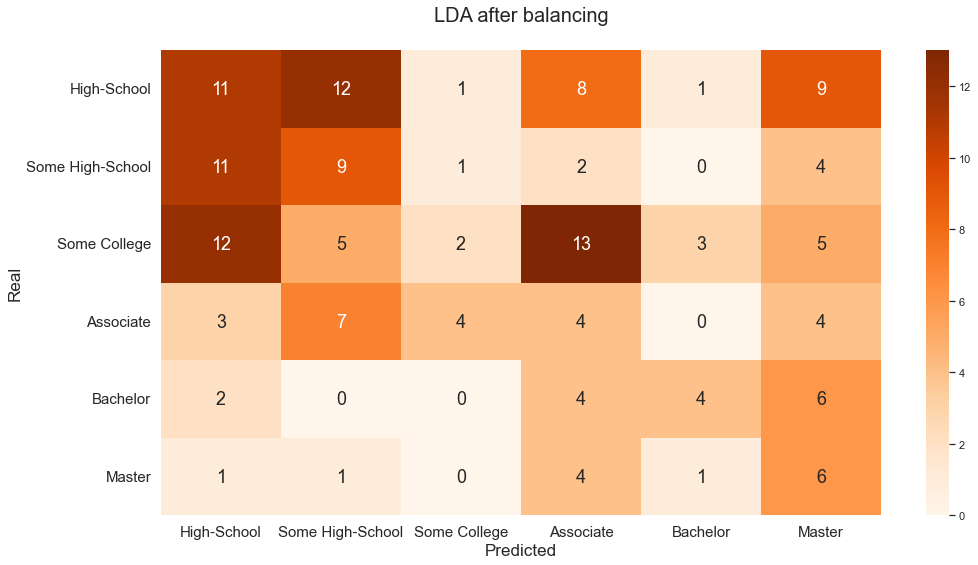

              precision    recall  f1-score   support

           0     0.2750    0.2619    0.2683        42
           1     0.2647    0.3333    0.2951        27
           2     0.2500    0.0500    0.0833        40
           3     0.1143    0.1818    0.1404        22
           4     0.4444    0.2500    0.3200        16
           5     0.1765    0.4615    0.2553        13

    accuracy                         0.2250       160
   macro avg     0.2542    0.2564    0.2271       160
weighted avg     0.2539    0.2250    0.2131       160
 

              precision    recall  f1-score   support

           0     0.2750    0.2619    0.2683        42
           1     0.2647    0.3333    0.2951        27
           2     0.2500    0.0500    0.0833        40
           3     0.1143    0.1818    0.1404        22
           4     0.4444    0.2500    0.3200        16
           5     0.1765    0.4615    0.2553        13

    accuracy                         0.2250       160
   macro avg     0.25

In [19]:
# Linear Discriminant Analysis
model = LinearDiscriminantAnalysis(solver='lsqr')
model.fit(X_su, y_su)

# make preds 
y_predictions =model.predict(X_test)
print(y_predictions.shape)

# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predictions)
fig, ax = plt.subplots(1,1,figsize=(15,8))
labels=['High-School','Some High-School','Some College','Associate','Bachelor','Master']
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix),
           annot=True,
           cmap="Oranges" ,
           fmt='g', 
           annot_kws={"size":18})
plt.ylabel('Real',fontsize=17)
plt.xlabel('Predicted',fontsize=17)
ax.set_xticklabels(labels, minor=False, fontsize=15)
ax.set_yticklabels(labels, minor=False, fontsize=15, rotation=0)

plt.title('LDA after balancing',y=1.05, fontsize=20)
plt.tight_layout()
plt.show()
plt.close()
print(classification_report(y_test, y_predictions, digits=4), '\n')
# make preds 
y_predictions =model.predict(X_test)

print(classification_report(y_test, y_predictions, digits=4), '\n')


# Predictions on unseen data 🔮
___

In [20]:
T = pd.read_csv(r"C:\Users\motxi\Documents\HACKATHONS\NUWE\Student Factors\test.csv")
T.rename(columns={ 'test preparation course':'test_prep'}, inplace=True)
T['total_score'] = (T['math score']+T['reading score']+T['writing score'])
T.drop(columns=['Unnamed: 0', 'math score','writing score', 'reading score'], inplace=True)

T.head()

,gender,lunch,test_prep,total_score
0,male,standard,none,142
1,female,standard,none,226
2,female,standard,none,284
3,male,standard,none,165
4,male,standard,none,153


In [21]:
# encode 
dummies = pd.get_dummies(T)

dummies = pd.DataFrame(scaler.transform(dummies))
dummies.head()

,0,1,2,3,4,5,6
0,-1.44,-1.00,1.00,-0.72,0.72,-0.74,0.74
1,0.49,1.00,-1.00,-0.72,0.72,-0.74,0.74
2,1.83,1.00,-1.00,-0.72,0.72,-0.74,0.74
3,-0.91,-1.00,1.00,-0.72,0.72,-0.74,0.74
4,-1.19,-1.00,1.00,-0.72,0.72,-0.74,0.74


### Submission of model results

In [22]:
# make preds 
y_predictions =model.predict(dummies)
preds = pd.DataFrame(y_predictions, columns=['target'])

# save as csv
preds.to_csv(r'C:\Users\motxi\Documents\HACKATHONS\NUWE\Student Factors\predictions.csv', index=False)

# save as json
preds.to_json(r'C:\Users\motxi\Documents\HACKATHONS\NUWE\Student Factors\predictions.json')

# Hypotesis Testing 🕵️‍♂️

>**"** Five criteria should be considered in trying to establish a causal relationship.
The first three criteria are generally considered as requirements for identifying a causal effect: 
    - (1) empirical association, 
    - (2) temporal priority of the independent variable, and 
    - (3) nonspuriousness.
You must establish these three to claim a causal relationship. Evidence that meets the other two criteria:
    - (4) identifying a causal mechanism, and 
    - (5) specifying the context in which the effect occurs can considerably strengthen causal explanations. **"** <sup>[2]</sup>

I'm not satisfied at all with this results above so I'mma resolve this straight away with Hypotesis testing:


- First we'll visually check 10% of the students with most extreme scores (best and worst) and their parental level of Education.


- We'll create 3 strata made of total scores:

    - "Group College" : A stratum comprised only of students' grades wich parents went to University.
    
    - "Group High-School" : A second stratum comprised only of students' grades wich parents didn't continued their academical path beyond High-School.
        
    - "Control" : A third stratum randomly selected.
    
    
- After that we'll make some asumption checks , to inquire about normality and variance, so to know if next steps require parametric/nonparametric/.


- Finally we'll apply the proper tests according to assumption checks.

### Visual Checks

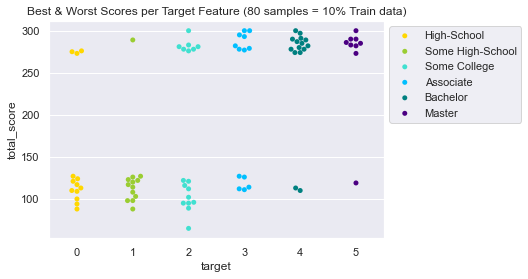

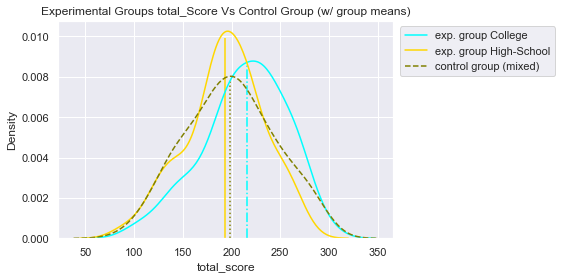

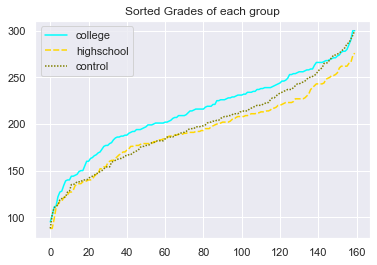

In [23]:

# top/bottom 80 in qualifications
top = df.nlargest(40, 'total_score')
bottom = df.nsmallest(40, 'total_score')

# concat in a df
aux_df = pd.concat([top, bottom], axis=0)
# plot
sb.swarmplot(data=aux_df, 
               x='target',
               y='total_score', 
               palette=['gold','yellowgreen','turquoise','deepskyblue','teal','indigo'])

plt.title('Best & Worst Scores per Target Feature (80 samples = 10% Train data)')
plt.legend(labels=['High-School','Some High-School','Some College','Associate','Bachelor','Master'],
           bbox_to_anchor=(1, 1))
plt.show()
plt.close()


# get strata 10% each one
group_college = df['total_score'].loc[df['target']>=2].sample(n=160, random_state=1).reset_index(drop=True)
group_highschool = df['total_score'].loc[df['target']<2].sample(n=160, random_state=1).reset_index(drop=True)
control = df['total_score'].sample(frac=0.2,random_state=1).reset_index(drop=True)
group_names = ['group_college', 'group_highschool', 'control']


# plot
l1 = sb.kdeplot(x=group_college, color='cyan', label='exp. group College')
l2 = sb.kdeplot(x=group_highschool, color='gold', label='exp. group High-School')
l3 = sb.kdeplot(x=control, color='olive', linestyle='dashed', label='control group (mixed)')
plt.vlines(x=group_college.median(), ymin=0, ymax=0.0086, color='cyan', linestyle='dashdot')
plt.vlines(x=group_highschool.median(), ymin=0, ymax=0.0099, color='gold')
plt.vlines(x=control.median(), ymin=0, ymax=0.0079, color='olive', linestyle='dotted')

plt.legend(bbox_to_anchor=(1.5, 1.))
plt.title('Experimental Groups total_Score Vs Control Group (w/ group means)')
plt.show()
plt.close()

a = pd.DataFrame(sorted(group_college)).reset_index(drop=True)
b = pd.DataFrame(sorted(group_highschool)).reset_index(drop=True)
c = pd.DataFrame(sorted(control)).reset_index(drop=True)
groups = pd.concat([a,b,c], axis=1)
groups.columns = ['college', 'highschool', 'control']

sb.lineplot(data=groups, palette=['cyan', 'gold','olive'])
plt.title('Sorted Grades of each group')
plt.show()
plt.close()

### Stating the Hypotesis 

Main question: **Do students score better grades when their parents have higher tuition levels**

H<sub>0</sub> : The mean of the samples is the same (there's no significant difference between scores of each group).

H<sub>1</sub> : At least one of them is different. 

### Assumption Checks

- **Normality**

H<sub>0</sub> : The data is normally distributed.

H<sub>1</sub> : Data is not Gaussian.

GROUP COLLEGE
p value:0.0185
Reject null hypothesis >> The data is not normally distributed

GROUP HIGH-SCHOOL
p value:0.0742
Fail to reject null hypothesis >> The data is normally distributed

CONTROL
p value:0.3992
Fail to reject null hypothesis >> The data is normally distributed


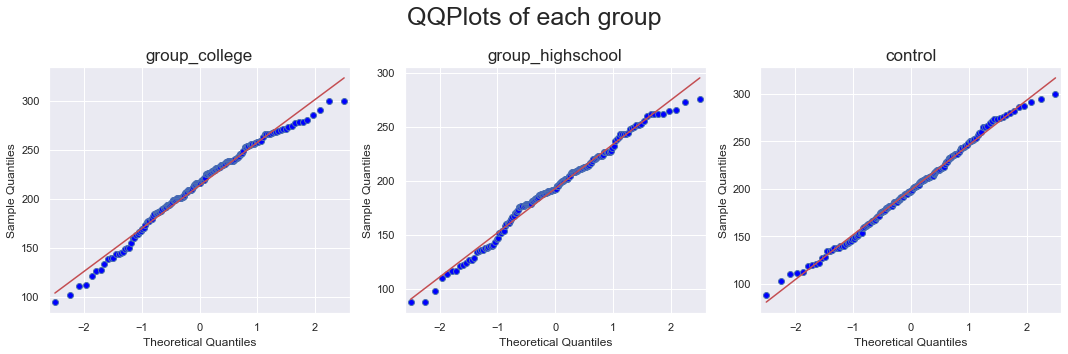

In [24]:
# normality
print('GROUP COLLEGE')
check_normality(group_college)
print('\nGROUP HIGH-SCHOOL')
check_normality(group_highschool)
print('\nCONTROL')
check_normality(control)

# qqplots
groups = [group_college, group_highschool, control]

fig = plt.figure(figsize=(15,5))
for i, group in enumerate(groups):
        ax=fig.add_subplot(1,3,i+1)
        sm.qqplot(group.values,line='r', ax=ax)
        plt.title(group_names[i], fontsize=17)
plt.suptitle('QQPlots of each group',fontsize=25)
plt.tight_layout()
plt.show()
plt.close()

- **Variance homogeneity**

H<sub>0</sub> : The variances of the samples are the same.


H<sub>1</sub> : The variances of the samples are different.

In [25]:
# Leven's test centered at the median
stat, pvalue_levene= stats.levene(group_college, group_highschool, control, center='median')
print("CENTERED AT THE MEDIAN\n p value:%.4f" % pvalue_levene)
if pvalue_levene <0.05:
    print(" Reject null hypothesis >> The variances of the samples are significantly different.\n")
else:
    print(" Fail to reject null hypothesis >> The variances of the samples are the same.\n")
    

# Leven's test centered at the mean
stat, pvalue_levene= stats.levene(group_college,group_highschool,control, center='mean')
print("CENTERED AT THE MEAN\n p value:%.4f" % pvalue_levene)
if pvalue_levene <0.05:
    print(" Reject null hypothesis >> The variances of the samples are significantly different.")
else:
    print(" Fail to reject null hypothesis >> The variances of the samples are the same.")
    

CENTERED AT THE MEDIAN
 p value:0.1279
 Fail to reject null hypothesis >> The variances of the samples are the same.

CENTERED AT THE MEAN
 p value:0.1247
 Fail to reject null hypothesis >> The variances of the samples are the same.


- **Statistical Test**

In [26]:
# check difference between groups
test = f_oneway(group_college,group_highschool,control)
if test.pvalue < 0.05:
    print(f"STATISTICAL TEST\n p value:{test.pvalue.round(6)} \n Reject null hypothesis >> At least one of the group means is different.")
else:
    print(f"STATISTICAL TEST\n p value:{test.pvalue.round(6)} \n Fail to reject null hypothesis >> The mean of the groups is the same.")

STATISTICAL TEST
 p value:7.4e-05 
 Reject null hypothesis >> At least one of the group means is different.


To know wich groups are different from each other we need a posthoc test so we'll use a Tukey's test

In [27]:
# apply posthoc ttest for global difference assessment
posthoc_df= sp.posthoc_ttest([group_college,group_highschool,control], p_adjust='bonferroni')
posthoc_df.columns= group_names
posthoc_df.index = group_names
posthoc_df.style.applymap(lambda x: ("background-color:teal") if x<0.05 else ("background-color: darkorange"))

# apply pairwise

,group_college,group_highschool,control
group_college,1.00,0.00,0.01
group_highschool,0.00,1.00,0.66
control,0.01,0.66,1.00


## Discussion 

According to results above we can conclude that:

- There's a difference between the scores of the students from College and the other two groups. 

Although we can exclude causality since we have no means to assess it properly


# Sources 📚

- [1]. [Learn Statistics with Python](https://ethanweed.github.io/pythonbook/05.03-anova.html#)

- [2]. [Causation and Experimental Design](https://www.sagepub.com/sites/default/files/upm-binaries/23639_Chapter_5___Causation_and_Experimental_Design.pdf)